TO DO:
[] interpret coeff & feature importance
[] ROC AUC

[] PCA Explained Variance graph


# 05. Modeling with PCA
___


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score

from sklearn.model_selection import GridSearchCV




___


Introduction


In this notebook, I will be building two types classification models. Using Logistic Regression and Decision Trees, we will see if we can correctly classify our target variable and predict the classes of new datapoints.
I will train each model with a portion of the dataset and then compare the outputs with my test set. 


___


In [54]:
heart22 = pd.read_csv('~/Desktop/capstone-project-Tasnimacj/data/cleaned_data/heart22_preprocessed.csv',index_col=0 )

In [55]:
heart22.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246013 entries, 0 to 246012
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Female                         246013 non-null  int64  
 1   GeneralHealth                  246013 non-null  int64  
 2   PhysicalHealthDays             246013 non-null  float64
 3   MentalHealthDays               246013 non-null  float64
 4   LastCheckupTime                246013 non-null  int64  
 5   PhysicalActivities             246013 non-null  int64  
 6   SleepHours                     246013 non-null  float64
 7   RemovedTeeth                   246013 non-null  int64  
 8   HadHeartAttack                 246013 non-null  int64  
 9   HadAngina                      246013 non-null  int64  
 10  HadStroke                      246013 non-null  int64  
 11  HadAsthma                      246013 non-null  int64  
 12  HadSkinCancer                  2460

Here I load in the data that we saved from the previous notebook. Checking if our dataset is properly encoded, with 0 null values and has a correct index. Everything looks good, so we can move straight into modeling now.

In [56]:
y = heart22['HadAngina'] # Target Variable
X = heart22.drop('HadAngina', axis=1) 

In [57]:
print('Shape of y:', y.shape)
print('Shape of X:', X.shape)

Shape of y: (246013,)
Shape of X: (246013, 41)


Split our data into our feature columns and our target variable. We will be putting our X into our models and comparing the outputs with our y.


In [58]:
#1st split

X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.2, random_state=25, stratify=y)

print(f'The remainder set has {len(X_rem)} data points.')
print(f'The test set has {len(X_test)} data points.')

The remainder set has 196810 data points.
The test set has 49203 data points.


For the model, we need to split our data into a training set and a test set. Here I did a 80:20 split, keeping an even distribution of y variables in each split. 
We use the train set to fit the model and then evaluate on the test set. Splitting the datapoints helps prevent overfitting and a way to accurately check model performance. By having unseen data, we can come close to replicating real life scenarios that the model will face.

___

### 1 PCA


I will plot an explained variance graph to see if we need PCA.

In [59]:
ss = StandardScaler().fit(X_rem)
X_rem_ss = ss.transform(X_rem)
X_test_ss = ss.transform(X_test)

In [60]:
print(f"The X1 axis values have variance: {np.var(X_rem_ss[:,0]):0.2f}")
print(f"The X2 axis values have variance: {np.var(X_rem_ss[:,1]):0.2f}")

The X1 axis values have variance: 1.00
The X2 axis values have variance: 1.00


In [61]:
print(f"The two axis have correlation: {np.corrcoef(X_rem_ss[:,0], X_rem_ss[:,1])[0,1]:0.2f}")

The two axis have correlation: 0.02


weak correlation

In [62]:
my_PCA = PCA()

X_pca = my_PCA.fit_transform(X_rem_ss)


In [65]:
X_pca.shape

(196810, 41)

In [63]:
print(f"The X1_PCA axis values have variance: {np.var(X_pca[:,0]):0.2f}")
print(f"The X2_PCA axis values have variance: {np.var(X_pca[:,1]):0.2f}")

The X1_PCA axis values have variance: 4.56
The X2_PCA axis values have variance: 2.79


In [66]:
print(f"The two axis have correlation: {np.corrcoef(X_pca[:,0], X_pca[:,1])[0,1]:0.2f}")

The two axis have correlation: -0.00


In [75]:
ex_var_ratio = my_PCA.explained_variance_ratio_

ex_var_ratio

array([0.11132925, 0.0680004 , 0.05572923, 0.03943203, 0.03838521,
       0.03148202, 0.02830254, 0.02740439, 0.02669218, 0.02571383,
       0.02489283, 0.02428743, 0.02408577, 0.02370368, 0.02344469,
       0.02299635, 0.02259557, 0.02186955, 0.02116488, 0.02102949,
       0.02058346, 0.01995303, 0.019775  , 0.01961808, 0.0192491 ,
       0.01880456, 0.01856819, 0.01816608, 0.01763422, 0.01675282,
       0.01654482, 0.01580101, 0.0147906 , 0.01469905, 0.01348372,
       0.01308221, 0.01254683, 0.01108528, 0.00891798, 0.00722446,
       0.0001782 ])

Scree Plot

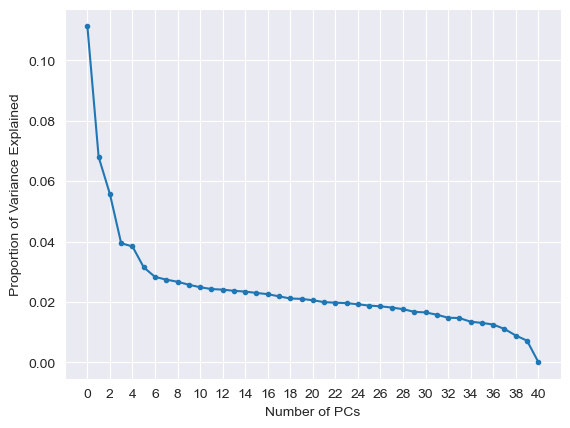

In [74]:
plt.figure()
sns.set_style('darkgrid')

plt.plot(range(0,41),ex_var_ratio,marker='.')

plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')

plt.xticks(range(0,41,2))


plt.show()

Threshold Explained Variance

In [76]:
cumulative_sum = np.cumsum(ex_var_ratio)

cumulative_sum

array([0.11132925, 0.17932965, 0.23505888, 0.27449091, 0.31287612,
       0.34435815, 0.37266068, 0.40006507, 0.42675725, 0.45247108,
       0.47736391, 0.50165134, 0.5257371 , 0.54944078, 0.57288547,
       0.59588182, 0.6184774 , 0.64034695, 0.66151183, 0.68254132,
       0.70312478, 0.72307782, 0.74285282, 0.76247089, 0.78171999,
       0.80052455, 0.81909274, 0.83725882, 0.85489304, 0.87164586,
       0.88819068, 0.90399169, 0.91878228, 0.93348133, 0.94696505,
       0.96004725, 0.97259409, 0.98367937, 0.99259735, 0.9998218 ,
       1.        ])

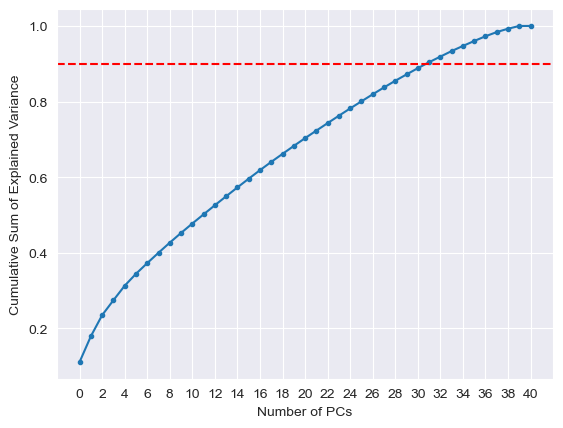

In [77]:

plt.figure()

plt.plot(range(0,41), cumulative_sum, marker='.')

plt.axhline(0.9, c='red', linestyle='--')

plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Sum of Explained Variance')

plt.xticks(range(0,41,2))



plt.show()

___

### 2 Tuning Logistic Regression

Pipeline

Using a pipeline, I want to find the best hyperparameters for my model. I set up a pipeline that contains a scaler, dimension reducer and a model of our choice. 

In [13]:
from tempfile import mkdtemp
cachedir = mkdtemp()

In [14]:
pipe = Pipeline([("scaler", StandardScaler()),
                 ("my_pca", PCA()),
                 ("model", LogisticRegression())], memory=cachedir)

Hyperparameter Optimisation

Setting up a parameter grid with what I would like to change in my model. I want to explore different c values and the model penalty. For now, I only want to scale my data using a standard scaler and look at the top 20 components.

In [15]:

n_components = [1,21,30,36,41]
c_values = [.0001, .001, .01, .1, 1, 10, 100, 1000, 10000]


log_reg_param = [

    {'scaler': [ StandardScaler()],
     'my_pca__n_components': n_components,
     'model': [LogisticRegression(solver='saga',random_state=1, n_jobs=-1, max_iter=10000)], 
     'model__C': c_values,
     'model__penalty': ['l1', 'l2'],
    }
]

GridSearch

In [16]:
grid = GridSearchCV(estimator=pipe,param_grid=log_reg_param, cv=5,verbose=1,refit=True)

In [17]:
fittedgrid_lr = grid.fit(X_rem,y_rem)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


In [18]:
fittedgrid_lr.best_params_

{'model': LogisticRegression(C=0.1, max_iter=10000, n_jobs=-1, penalty='l1',
                    random_state=1, solver='saga'),
 'model__C': 0.1,
 'model__penalty': 'l1',
 'my_pca__n_components': 42,
 'scaler': StandardScaler()}

GridSearch looks at different parameter settings across 5 cross folds on our Remainder set. It does this to find the best model settings whilst preventing data leakage and overfitting on our train set. 
GridSearch has found that the best parameters for our Logistic Regression is having a C value of 0.001, which means we need a strong regularization strength. We need a l2 penalty to help shrink coefficients to 0.

In [19]:

fittedgrid_lr.best_estimator_.named_steps["my_pca"].explained_variance_ratio_

array([0.10867879, 0.06638404, 0.0544024 , 0.03850575, 0.03747953,
       0.03088325, 0.02762925, 0.02715707, 0.02622969, 0.0251017 ,
       0.02463137, 0.02377998, 0.02359324, 0.02321551, 0.02306199,
       0.02252129, 0.02234293, 0.02204065, 0.02133764, 0.02065731,
       0.02052838, 0.02009333, 0.01947108, 0.01928274, 0.01914945,
       0.01878889, 0.0183549 , 0.01812281, 0.01772569, 0.01721017,
       0.01635393, 0.01614333, 0.0154235 , 0.01443827, 0.01434745,
       0.01316267, 0.01276987, 0.01224748, 0.01082134, 0.00870564,
       0.00705175, 0.00017395])

In [20]:
print(f"Best accuracy on the remainder set: {fittedgrid_lr.score(X_rem, y_rem)}")
print(f"Best accuracy on the test set: {fittedgrid_lr.score(X_test, y_test)}")

Best accuracy on the remainder set: 0.9450993343834154
Best accuracy on the test set: 0.944556226246367


In [21]:
y_test_pred = fittedgrid_lr.predict(X_test)

conmat = pd.DataFrame(
    data = confusion_matrix(y_test, y_test_pred),
    index = ['true 0', 'true 1'],
    columns = ['predicted 0', 'predicted 1']
)
display(conmat)

print(f'Recall score: {recall_score(y_test, y_test_pred)*100:0.2f}%')
print(f'Precision score: {precision_score(y_test, y_test_pred)*100:0.2f}%')
print(f'F1 score: {f1_score(y_test, y_test_pred)*100:0.2f}%')

,predicted 0,predicted 1
true 0,45641,571
true 1,2157,834


Recall score: 27.88%
Precision score: 59.36%
F1 score: 37.94%


In [22]:
best_logreg_recall = round(recall_score(y_test, y_test_pred)*100, 2)
best_logreg_precision = round(precision_score(y_test, y_test_pred)*100, 2)
best_logreg_f1 = round(f1_score(y_test, y_test_pred)*100, 2)
best_logreg_accu = round(baseline_log_reg.score(X_test_ss, y_test)*100,2)

Our decided best logistic regression model is performing worse than our baseline in terms of recall.
 Perhaps PCA downgraded model performance, we can investigate this further in future notebooks.

___

### 3 Tuning Decision Tree

Pipeline

Setting up the pipeline for another classification model, this time I will use Decision Tree Classifier.

In [23]:
pipe = Pipeline([("scaler", StandardScaler()),
                 ("my_pca", PCA()),
                 ("dt_model", DecisionTreeClassifier())], memory=cachedir)

Hyperparameter Optimisation

For the parameter grid, this time I want to see if scaling data would make a change in modeling. I still 20 components for PCA but explore different options for the trees max_depth and min_samples_leaf.

In [24]:

dt_param  = {"scaler":[StandardScaler(), None],
            "my_pca__n_components":n_components,
            "dt_model__max_depth": [None, 2, 4, 6, 8,10],
            "dt_model__min_samples_leaf": [2, 5, 10] }

In [31]:
# pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'my_pca', 'dt_model', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'my_pca__copy', 'my_pca__iterated_power', 'my_pca__n_components', 'my_pca__random_state', 'my_pca__svd_solver', 'my_pca__tol', 'my_pca__whiten', 'dt_model__ccp_alpha', 'dt_model__class_weight', 'dt_model__criterion', 'dt_model__max_depth', 'dt_model__max_features', 'dt_model__max_leaf_nodes', 'dt_model__min_impurity_decrease', 'dt_model__min_impurity_split', 'dt_model__min_samples_leaf', 'dt_model__min_samples_split', 'dt_model__min_weight_fraction_leaf', 'dt_model__random_state', 'dt_model__splitter'])

GridSearch

In [25]:
grid = GridSearchCV(estimator=pipe,param_grid=dt_param, cv=5,verbose=1,refit=True)

In [27]:
fittedgrid_dt = grid.fit(X_rem,y_rem)


Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [28]:
fittedgrid_dt.best_params_

{'dt_model__max_depth': 6,
 'dt_model__min_samples_leaf': 10,
 'my_pca__n_components': 42,
 'scaler': None}

In [29]:

fittedgrid_dt.best_estimator_.named_steps["my_pca"].explained_variance_ratio_

array([9.99999871e-01, 9.64554119e-08, 1.76460782e-08, 9.54886470e-09,
       2.35932825e-09, 1.94233601e-09, 4.00275239e-10, 1.72723910e-10,
       1.22525572e-10, 1.07974702e-10, 5.73226397e-11, 4.75706800e-11,
       4.59313468e-11, 4.07281865e-11, 3.93998841e-11, 3.75012607e-11,
       3.63984481e-11, 3.04232541e-11, 2.96324367e-11, 2.78576953e-11,
       2.51186285e-11, 2.28694243e-11, 2.12454377e-11, 1.89566924e-11,
       1.88673379e-11, 1.60354332e-11, 1.48154247e-11, 1.40767829e-11,
       1.34217100e-11, 1.22677189e-11, 1.11873360e-11, 9.63592596e-12,
       9.25913410e-12, 8.99966940e-12, 8.45928587e-12, 7.98832122e-12,
       7.92775187e-12, 7.32022377e-12, 6.90823391e-12, 4.48517558e-12,
       4.26568231e-12, 1.18006646e-13])

The best optimization for our decision tree would be using a standard scaler, having a max_depth of 6 and 10 min_samples_leaf. Scaling my data beforehand seems to be a crucial step for modeling.

In [30]:
print(f"Best accuracy on the remainder set: {fittedgrid_dt.score(X_rem, y_rem)}")
print(f"Best accuracy on the test set: {fittedgrid_dt.score(X_test, y_test)}")

Best accuracy on the remainder set: 0.9437172907880698
Best accuracy on the test set: 0.9420970266040689


Our accuracies are, again, similar to each other. We have no issue with over/underfitting. The accuracies being in the 90s shows that it is very confident in predicting classes correctly. 

In [31]:

y_test_pred = fittedgrid_dt.predict(X_test)

conmat = pd.DataFrame(
    data = confusion_matrix(y_test, y_test_pred),
    index = ['true 0', 'true 1'],
    columns = ['predicted 0', 'predicted 1']
)
display(conmat)

print(f'Recall score: {recall_score(y_test, y_test_pred)*100:0.2f}%')
print(f'Precision score: {precision_score(y_test, y_test_pred)*100:0.2f}%')
print(f'F1 score: {f1_score(y_test, y_test_pred)*100:0.2f}%')

,predicted 0,predicted 1
true 0,45486,726
true 1,2123,868


Recall score: 29.02%
Precision score: 54.45%
F1 score: 37.86%


In [32]:
best_dt_recall = round(recall_score(y_test, y_test_pred)*100, 2)
best_dt_precision = round(precision_score(y_test, y_test_pred)*100, 2)
best_dt_f1 = round(f1_score(y_test, y_test_pred)*100, 2)
best_dt_accu = round(baseline_log_reg.score(X_test_ss, y_test)*100,2)

Our recall score has plummeted to 8%. This model is very bad classifying '1's, so it is unusable.
The precision is around 50%, so only about half of its '1' predictions were correct.   

___


Conclusion

In [74]:
data = {'F1 score' :[baseline_logreg_f1 ,best_logreg_f1 ,15.03,25.69,21.24],
       'Recall score':[baseline_logreg_recall ,best_logreg_recall ,8.79,48.41,41.49], 
       'Precision score':[baseline_logreg_precision,best_logreg_precision ,51.77,17.49,14.27],
       'Accuracy':[baseline_logreg_accu,best_logreg_accu,93.96,82.98,81.29]}


scores = pd.DataFrame(
    data = data,
    index = ['Baseline LogReg', 'Best LogReg', 'Best DT','Best SMOTE LogReg', 'Best SMOTE DT' ],
    columns = ['F1 score','Recall score', 'Precision score', 'Accuracy']
)

Here is a table that compares the F1, Recall, Precision and Test Accuracy for each model.

In [75]:
scores

,F1 score,Recall score,Precision score,Accuracy
Baseline LogReg,38.06,27.98,59.49,94.46
Best LogReg,28.24,18.46,60.07,94.30
Best DT,15.03,8.79,51.77,93.96
Best SMOTE LogReg,25.69,48.41,17.49,82.98
Best SMOTE DT,21.24,41.49,14.27,81.29


Before sampling, my best model was my baseline model. After sampling, I found that my recall improves, which is what I ultimately want.  In future notebooks, I will be looking at modelling without PCA, and trying different hyperparameters. 
I will have to look into different combinations for my model that would give me a good recall score but also not affect the precision as much.